
# Load Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
import keras 

X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')
max_length = int(np.load('data/max.npy'))

/home/rommeltf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if len(set(y_train)) == 2:
    num_classes = 2
    activation = 'sigmoid'
    loss = keras.losses.binary_crossentropy
    output = 1
else:
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    activation = 'softmax'
    loss = keras.losses.categorical_crossentropy
    output = 10 


In [3]:
X_train.shape

(557, 1020, 3)

In [4]:
y_train.shape

(557,)

In [5]:
X_test.shape

(62, 1020, 3)

In [6]:
X_train.shape[1]

1020

In [7]:
import pywt
from scipy import signal

#rng = X_train.shape[1]
rng = 256
scales = range(1, rng + 1)
waveletname = 'mexh'
dt = 0.0512  # 512 Hz sampling
widths = pywt.scale2frequency(waveletname, scales) / dt


def create_plots(sample, color):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals, cwt and target response 
    '''

    plt.figure(figsize=(35,5))

    plt.subplot(1,7,1)
    plt.plot(X_train[sample, :, 0])

    plt.subplot(1,7,2)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 0], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

    plt.subplot(1,7,3)
    plt.plot(X_train[sample, :, 1])

    plt.subplot(1,7,4)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 1], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    plt.subplot(1,7,5)
    plt.plot(X_train[sample, :, 2])

    plt.subplot(1,7,6)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 2], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    
    plt.subplot(1,7,7)
    plt.text(0.35, 0.5, y_train[sample], dict(size=30))

    plt.show()

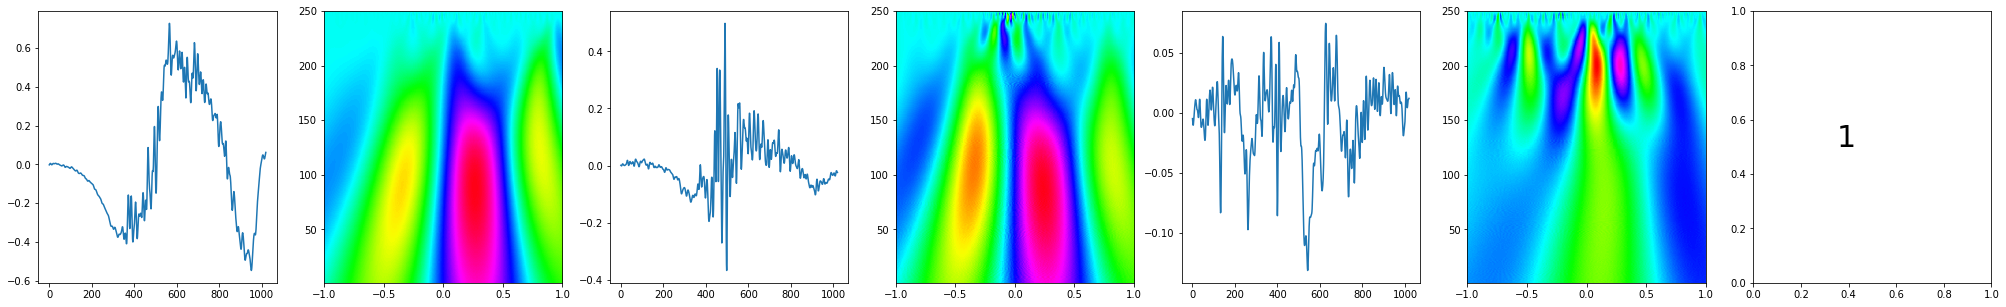

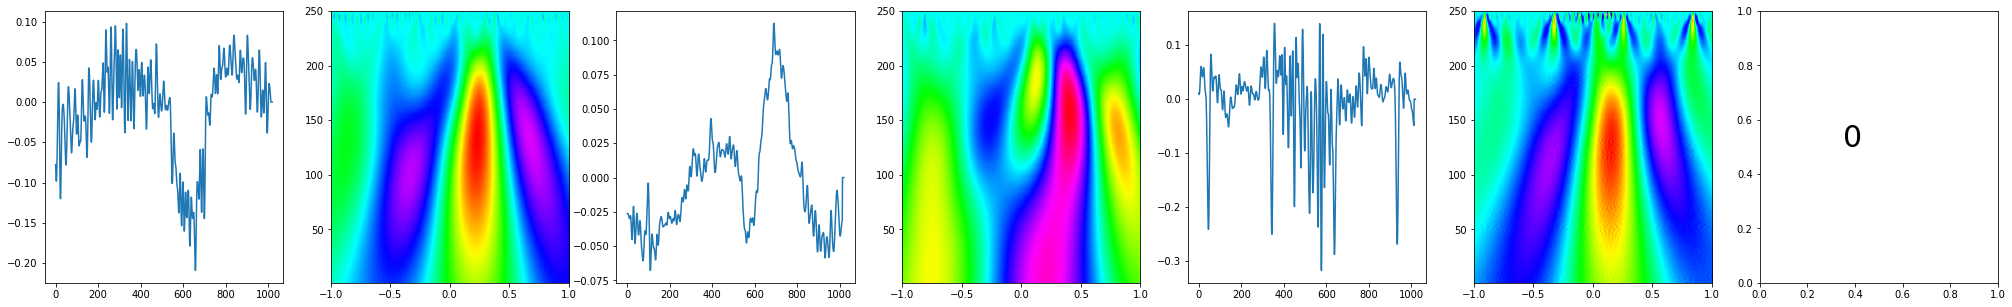

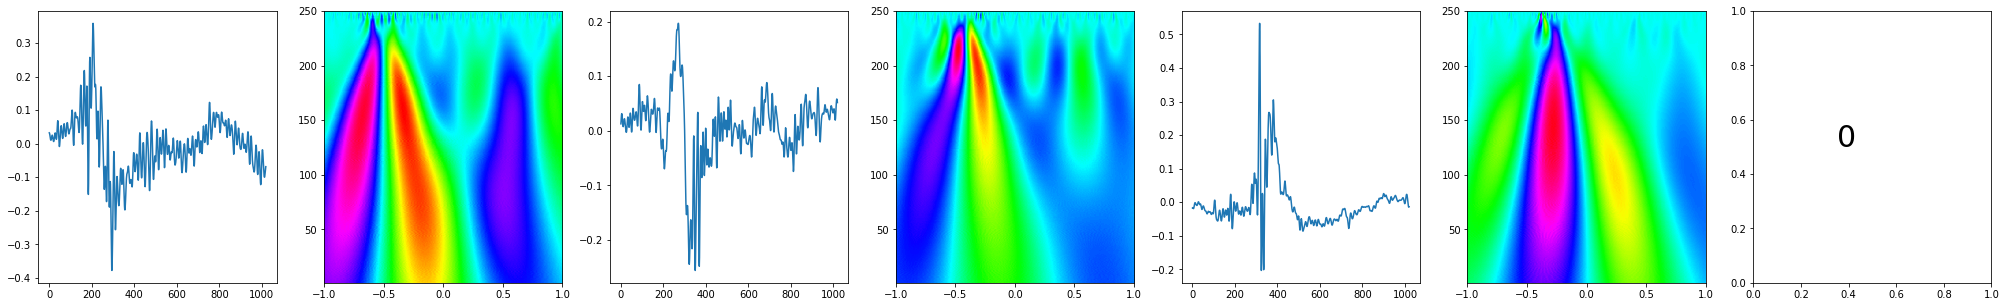

In [8]:
for i in [21,22,23]:
    create_plots(i,'hsv')

# Generate CWT transformations 

In [9]:
import pywt 

train_size = X_train.shape[0]
test_size= X_test.shape[0]


train_data_cwt = np.ndarray(shape=(train_size, rng, rng, 3))

for i in range(0,train_size):
    for j in range(0,3):
        signal = X_train[i, :, j]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:rng]
        train_data_cwt[i, :, :, j] = coeff_

test_data_cwt = np.ndarray(shape=(test_size, rng, rng, 3))

for i in range(0,test_size):
    for j in range(0,3):
        signal = X_test[i, :, j]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:rng]
        test_data_cwt[i, :, :, j] = coeff_


X_train = train_data_cwt
X_test = test_data_cwt

np.save('X_train', X_train)
np.save('X_test', X_test)

In [17]:
# After CWT transformations 

X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')

In [11]:
X_train.shape

(557, 250, 250, 3)

In [12]:
y_train.shape[-1]

557

In [13]:
X_test.shape

(62, 250, 250, 3)

In [14]:
y_test.shape

(62,)

In [15]:
y_test

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])

# Model with CWT-CNN 

In [18]:
import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

img_x = X_train.shape[1]
img_y = X_train.shape[1]
img_z = X_train.shape[-1]
input_shape = (img_x, img_y, img_z)

batch_size = 16
epochs = 25

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(output, activation=activation))

model.compile(loss=loss,
              optimizer=keras.optimizers.Adam(lr = 0.0001),
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train on 557 samples, validate on 62 samples
Epoch 1/25


ResourceExhaustedError: OOM when allocating tensor of shape [238144,512] and type float
	 [[Node: training_1/Adam/zeros_12 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [238144,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training_1/Adam/zeros_12', defined at:
  File "/home/rommeltf/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rommeltf/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/rommeltf/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/rommeltf/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/rommeltf/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-51248bd3d241>", line 42, in <module>
    callbacks=[history])
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1008, in fit
    self._make_train_function()
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 483, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 483, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 700, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1551, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2794, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/rommeltf/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [238144,512] and type float
	 [[Node: training_1/Adam/zeros_12 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [238144,512] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
### Plot Losss
def plot_loss():
    acc = history.history['acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_loss()

In [ ]:
### Plot accuracy 

def plot_accuracy():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acccuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation acccuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
    
plot_accuracy()

In [ ]:
#Testing Scores 
from sklearn.metrics import classification_report
import numpy as np

if y_train.shape[-1] == 10:
    y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

In [ ]:
import pydot
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='lstm.png')
Image(filename='lstm.png') 

# Conv1D 

In [ ]:
from keras.layers import Conv1D, MaxPooling1D

X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')
max_length = int(np.load('data/max.npy'))


img_y = X_train.shape[1]
img_z = X_train.shape[-1]

input_shape = (img_y, img_z)

batch_size = 16
epochs = 25

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model = Sequential()
model.add(Conv1D(400, kernel_size=3, strides=1,
                 activation='relu',
                 input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(400, 3, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(output, activation=activation))

model.compile(loss=loss,
              optimizer=keras.optimizers.Adam(lr = 0.0001),
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

In [ ]:
plot_loss()

In [ ]:
plot_accuracy()

In [ ]:
if y_train.shape[-1] == 10:
    y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
plot_model(model, to_file='lstm.png')
Image(filename='lstm.png') 